# California Housing Price Prediction

We will use California census data to build a model of housing prices in the state. This data includes metrics such as the population, median income, and median housing price for each block group in California.

Importing required libraries

In [95]:
import os
import tarfile
import urllib
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from scipy import stats

In [2]:
DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml/tree/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

The following method fetches the data using the (DOWNLOAD_ROOT) URL mentioned above and extracts into a directory on the system.

In [3]:
def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
#fetch_housing_data(HOUSING_URL, HOUSING_PATH)

The below function returns the pandas DataFrame object by using the file at the path provided as the parameter.

In [5]:
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [6]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Attribute **ocean_proximity** is a categorical feature. All other features are continous.

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Attribute **total_bedrooms** has some missing values. We will need to take care of this later.

The categorical variable **ocean_proximity** has 5 different values.

In [8]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Plotting the histograms of all numeric attributes to check the distribution. Calling the hist() method on the whole dataset will plot a histogram for each attribute.

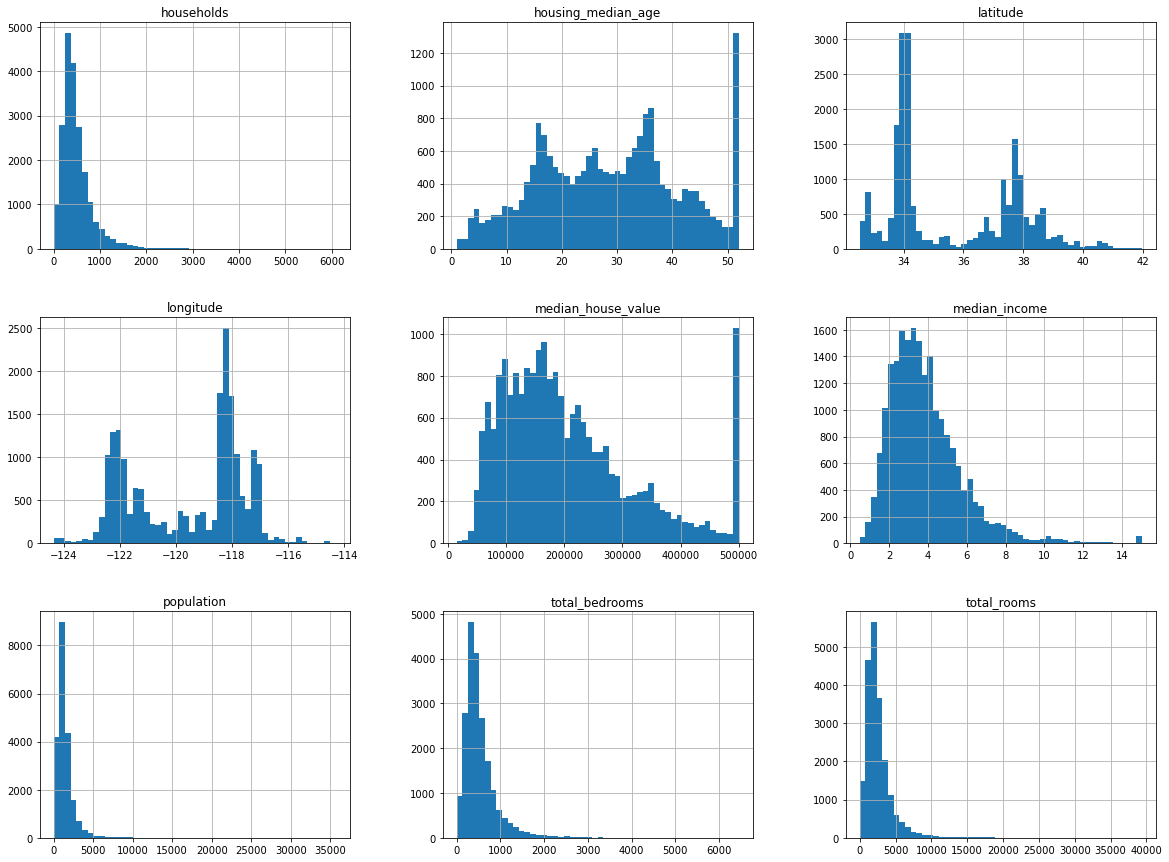

In [10]:
housing.hist(bins = 50, figsize=(20, 15))
plt.show()

Taking 20% as the test dataset size, we will split the data into training and testing sets using permutation function of the random module in numpy.

In [11]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [12]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set))
print(len(test_set))

16512
4128


We categorise the **median_income** attribute to better understand the income distribution and split the dataset later in a stratified manner based on the income groups. A new attribute **income_cat** is created.

In [13]:
housing["income_cat"] = pd.cut(housing["median_income"], 
                               bins=[0, 1.5, 3, 4.5, 6, np.inf], 
                              labels = [1, 2, 3, 4, 5])

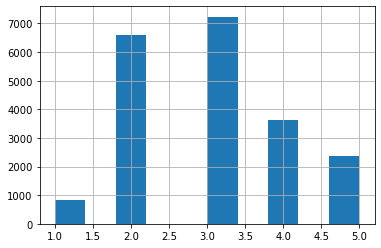

In [14]:
housing["income_cat"].hist()

Using StratifiedShuffleSplit to split the housing dataset into training set, **strat_train_set** and testing set, **strat_test_set** based on the new attribute **income_cat** created above.

In [15]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Below is the distribution of various income groups in the stratified testing set

In [16]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

Once the training set and testing set have been created using the StratifiedShuffleSplit, we can remove the **income_cat** attribute.

In [17]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis = 1, inplace = True)

Creating a copy of the stratified testing set for further analysis.

In [18]:
housing = strat_train_set.copy()

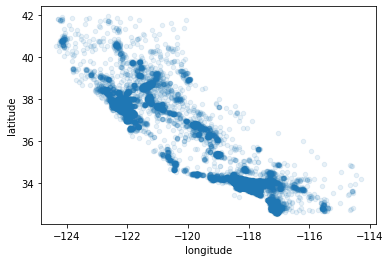

In [19]:
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.1)

Below plot shows that most population is concentration in the southern part of the stateand houses near the ocean have more value.

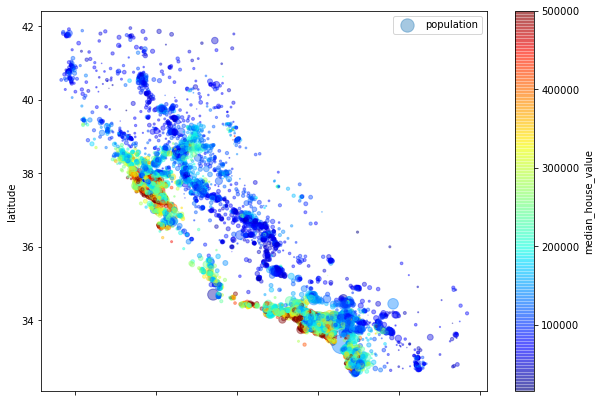

In [20]:
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.4, s = housing['population'] / 100, 
             label = 'population', figsize = (10, 7), c = "median_house_value", cmap = plt.get_cmap('jet'), colorbar = True)
plt.legend();

In [21]:
corr_matrix = housing.corr()

In [23]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


This shows that **median_house_value** is highly correlated to the attribute **median_income**

In [24]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Creating a scatter matrix using scatter_matrix in pandas.plotting also shows the correlation between 4 most correlated attributes with respect to the **median_housing_value**.

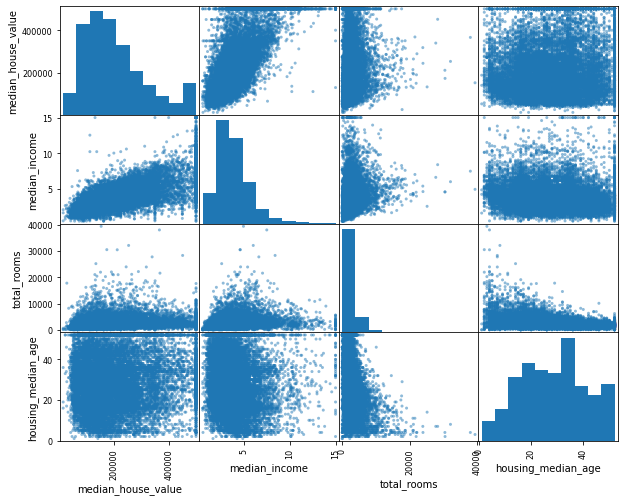

In [25]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(10, 8));

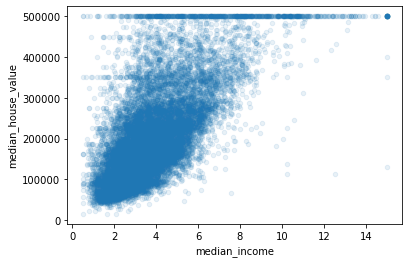

In [30]:
housing.plot(kind = "scatter", x = 'median_income', y = 'median_house_value', alpha = 0.1)

Feature Engineering:
1. Attribute **total_rooms** in a district is of no importance unless we know how many rooms are there per household, so we will create that feature
2. **total_bedrooms** is not useful if we don't know how many bedrooms are there per room so, we will create that feature as well.
3. We will also create population per household to get an idea of the number of persons per household in a district.

In [26]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

We can see the newly created features have significantly more correlation to the **median_house_price**.

In [27]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

Creating another copy of the training set for missing value treatment.

In [28]:
housing = strat_train_set.drop('median_house_value', axis = 1)
housing_labels = strat_train_set['median_house_value'].copy()

We will use **SimpleImputer** to replace the missing values on all the numeric attributes with their corresponding **median** values.

In [29]:
imputer = SimpleImputer(strategy='median')

Since we will transform all the numeric features, we will drop **ocean_proximity** as it is a categorical feature.

In [30]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [31]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [32]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

We can confirm from **imputer.statistics_** that the median values have been imputed

In [33]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [34]:
X = imputer.transform(housing_num)

In [35]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index = housing_num.index)

In [36]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


We will use **OrdinalEncoder** to encode the categorical variable **ocean_proximity** to ordered numerical values which will be easier to comprehend for our training algorithms.

In [37]:
ordinal_encoder = OrdinalEncoder()

In [38]:
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [39]:
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [40]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

We can observe that the OrdinalEncoder has encoded the values near the coast far from each other which is not the case in our data. We will abandon this approach and go for **OneHotEncoder** instead.

In [41]:
cat_encoder = OneHotEncoder()

In [42]:
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [43]:
type(housing_cat_1hot)

scipy.sparse.csr.csr_matrix

In [44]:
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [45]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [46]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [47]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

Using **BaseEstimator** and **TransformerMixin** classes to create features

In [48]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population__per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population__per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population__per_household]

In [49]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)

In [50]:
housing_extra_attribs = attr_adder.transform(housing.values)

Here we create a **Pipeline** by combining the 3 steps of Imputing, adding new features and scaling the feature values.

In [51]:
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), 
                        ('attribs_adder', CombinedAttributesAdder()), 
                        ('std_scaler', StandardScaler())])

In [52]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [53]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

Using **ColumnTransformer** we create a pipeline containing the numeric as well as categorical attributes for transformation.

In [54]:
full_pipeline = ColumnTransformer([("num", num_pipeline, num_attribs), 
                                  ("cat", OneHotEncoder(), cat_attribs)])

**housing_prepared** is the final data prepared that can be used to train a model

In [55]:
housing_prepared = full_pipeline.fit_transform(housing)

In [56]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

We use some data to gauge the performance of **LinearRegression** using the predict method. The data will go through the pipeline defined.

In [57]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions: ", lin_reg.predict(some_data_prepared))
print("Labels: ", list(some_labels))

Predictions:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [58]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

The rmse score obtained is not very good. We will try other models.

In [59]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [60]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In most cases, an rmse of 0.0 would mean overfitting. We can confirm the same by using **cross_val_score**

In [61]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)

In [62]:
tree_rmse_scores = np.sqrt(-scores)

In [63]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())

In [64]:
display_scores(tree_rmse_scores)

Scores:  [68360.89026596 65513.25443528 72061.77500923 69321.00797636
 70262.63252898 73712.41649252 69945.62414075 72674.05999089
 76272.52129586 71517.70249303]
Mean:  70964.18846288472
Standard Deviation:  2844.0363712940475


We observe that this performs worse than LinearRegression.

In [65]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv = 10)

In [66]:
lin_rmse_scores = np.sqrt(-lin_scores)

In [67]:
display_scores(lin_rmse_scores)

Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean:  69052.46136345083
Standard Deviation:  2731.6740017983434


This is confirmed when we **cross validate** LinearRegression

In [68]:
forest_reg = RandomForestRegressor()

We will try RandomForestRegressor model

In [69]:
forest_reg

RandomForestRegressor()

In [70]:
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [71]:
housing_predictions = forest_reg.predict(housing_prepared)

In [72]:
forest_reg_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv = 10)

In [73]:
forest_rmse_scores = np.sqrt(-forest_reg_scores)

In [74]:
display_scores(forest_rmse_scores)

Scores:  [49428.38392363 47240.31611399 50061.7286848  52513.70998813
 49629.89189128 53876.8572395  48250.88058656 48078.17093611
 52980.63445172 50489.8935293 ]
Mean:  50255.04673450206
Standard Deviation:  2113.260163877944


Keeping the parameters same, RandomForestRegressor provides better performance. We will now attempt to improve this score by using **GridSearchCV**

In [76]:
param_grid = [{'n_estimators':[3, 10, 30], 'max_features': [2, 4, 6, 8]}, 
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}]

In [77]:
forest_reg = RandomForestRegressor()

In [78]:
grid_search = GridSearchCV(forest_reg, param_grid=param_grid, cv = 5, scoring="neg_mean_squared_error", return_train_score=True)

In [79]:
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [80]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [81]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [82]:
cvres = grid_search.cv_results_

In [83]:
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

65299.02374492613 {'max_features': 2, 'n_estimators': 3}
55313.746691452936 {'max_features': 2, 'n_estimators': 10}
52940.95566860161 {'max_features': 2, 'n_estimators': 30}
60736.318235707615 {'max_features': 4, 'n_estimators': 3}
52653.22338186384 {'max_features': 4, 'n_estimators': 10}
50487.747912998086 {'max_features': 4, 'n_estimators': 30}
59464.66160164031 {'max_features': 6, 'n_estimators': 3}
52356.77630574468 {'max_features': 6, 'n_estimators': 10}
49957.66518771081 {'max_features': 6, 'n_estimators': 30}
59450.06780510732 {'max_features': 8, 'n_estimators': 3}
51742.1248612735 {'max_features': 8, 'n_estimators': 10}
50139.566578098675 {'max_features': 8, 'n_estimators': 30}
62026.07750002269 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54160.996176193825 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60419.98869897259 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52646.44121677572 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [84]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [85]:
feature_importances

array([7.54819091e-02, 6.93905785e-02, 4.25809445e-02, 1.82358672e-02,
       1.64622212e-02, 1.83251569e-02, 1.67392990e-02, 3.29400882e-01,
       6.39908379e-02, 1.02958403e-01, 6.55833509e-02, 1.73988638e-02,
       1.53370091e-01, 9.60497532e-05, 4.55918120e-03, 5.42636354e-03])

In [86]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

In [87]:
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3294008824595959, 'median_income'),
 (0.1533700908370867, 'INLAND'),
 (0.1029584032197966, 'pop_per_hhold'),
 (0.07548190911658392, 'longitude'),
 (0.06939057847750091, 'latitude'),
 (0.06558335094670152, 'bedrooms_per_room'),
 (0.06399083786613484, 'rooms_per_hhold'),
 (0.04258094446323229, 'housing_median_age'),
 (0.01832515694645357, 'population'),
 (0.018235867186621988, 'total_rooms'),
 (0.017398863759859808, '<1H OCEAN'),
 (0.016739299047208143, 'households'),
 (0.01646222118054597, 'total_bedrooms'),
 (0.005426363539489802, 'NEAR OCEAN'),
 (0.004559181199996093, 'NEAR BAY'),
 (9.604975319198369e-05, 'ISLAND')]

Finally, we will fit our data using the **best_estimator_** determined by grid search

In [88]:
final_model = grid_search.best_estimator_

In [89]:
X_test = strat_test_set.drop("median_house_value", 1)
y_test = strat_test_set["median_house_value"].copy()

In [90]:
X_test_prepared = full_pipeline.transform(X_test)

In [91]:
final_predictions = final_model.predict(X_test_prepared)

In [92]:
final_mse = mean_squared_error(y_test, final_predictions)

In [93]:
final_rmse = np.sqrt(final_mse)

In [94]:
final_rmse

47925.67980088771

In [96]:
confidence = 0.95

In [97]:
squared_errors = (final_predictions - y_test) ** 2

In [98]:
np.sqrt(stats.t.interval(confidence, 
                         len(squared_errors) - 1, 
                         loc = squared_errors.mean(), 
                        scale = stats.sem(squared_errors)))

array([45961.22931211, 49812.71894681])

Above set of values is the 955 confidence interval for the generalization error.